# Clicks Maximizer

This is a working version of the clicks-maximizer. It loads and prepares the auction dataset, tunes functions $f(\text{bid},X) = \mathbb{E}[\text{impressions}|\text{bid},X]$ and $g(\text{impressions},X) = \mathbb{E}[\text{clicks}|\text{impressions},X],$ and then applies constrained maximization to arrive at the clicks-maximizing vector of bids.

At the end there are a few graphs showing some basic findings about the resulting bid vector. 

For more information about how the clicks-maximizer works, see the document "Maximing Clicks". 

Warning: In case of error "cannot set WRITEABLE flag to True of this array", uninstall the scikit-sparse package. 

Author: Martin Wiegand

Last changed: 29.04.2022

In [1]:
# load packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pygam import LinearGAM, s
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit, minimize
from scipy import interpolate
from itertools import starmap
from sklearn.model_selection import KFold, train_test_split

#### Define functions to load the data, estimate $f$ and $g$, and solve the optimization problem. 

In [2]:
def load_dataset(folder: str) -> pd.DataFrame:
    """
    Load auction dataset. Construct time-related features. Create identifiers for 
    each cluster of observations for which we assume a homogenous relationship
    between bids and impressions, and impressions and clicks, respectively. 
    Remove clusters which have less than 2000 impressions. 
    Needs specification of the folder with the csv file 
    'test_param_performance_formatted.csv'.
    
    Parameters
    ----------
    folder: str

    Returns
    -------
    DataFrame
    """
    
    # Load dataset
    data = pd.read_csv(folder + "test_param_performance_formatted.csv")
    # Consider only auctions, not actions 
    data = data.loc[data["impressions"] > 0]
    # Drop columns with zero variance; also drop "booked_revenue_adv_curr" (as it
    # is redundant)
    data = data.drop(["advertiser_id", "insertion_order_id", "country", 
                      "region", "conversions_1433583", "conversions_1433581", 
                      "conversions_1433575", "booked_revenue_adv_curr"], axis=1)
    
    # Some dummies to indicate various times of the day, as well as weekend
    data["earlymorning"] = ((data["hour_user_tz"] >= 7) & (data["hour_user_tz"] < 9)) * 1
    data["latemorning"] = ((data["hour_user_tz"] >= 9) & (data["hour_user_tz"] < 11)) * 1
    data["noon"] = ((data["hour_user_tz"] >= 11) & (data["hour_user_tz"] < 13)) * 1
    data["afternoon"] = ((data["hour_user_tz"] >= 13) & (data["hour_user_tz"] < 18)) * 1
    data["evening"] = ((data["hour_user_tz"] >= 18) & (data["hour_user_tz"] < 23)) * 1
    data["earlynight"] = ((data["hour_user_tz"] == 23) | (data["hour_user_tz"] < 3)) * 1    
    data["latenight"] = ((data["hour_user_tz"] >= 3) & (data["hour_user_tz"] < 7)) * 1    
    data["weekend"] = ((data["weekday_user_tz"] == 0) | (data["weekday_user_tz"] == 6)) * 1
    
    # Generate variables indicating the first two letters of the 
    # custom_model_leaf_name from dataset 1. This is mainly to identify 
    # retargeted customers in the end. 
    ba_list = [13917115, 13917143, 13917188, 13917210, 13917281, 13917317, 
               13917402, 14273478, 14345556, 14345602, 14351599, 14351600, 
               14351602, 14950582, 14951140]
    RT_list = [13917415, 13917562, 13917595, 13917624, 13917701, 13917702, 
               13917703, 13917704, 13971302, 14004079, 14004080, 14004082]
    bami_list = [13934058, 13935850, 14602750]
    data["leaf_cat_2"] = "unknown" # first 2 letters of leaf category
    data.loc[data["line_item_id"].isin(ba_list), "leaf_cat_2"] = "ba"
    data.loc[data["line_item_id"].isin(RT_list), "leaf_cat_2"] = "RT"
    data.loc[data["line_item_id"].isin(bami_list), "leaf_cat_2"] = "bami" # (first 2 letters either ba or mi)
    data["RT"] = (data["leaf_cat_2"] == "RT") * 1
    
    # Create grouping by device type, line item, day, and time. These are the 
    # features for which we assume a homogenous relationship between bids and
    # impressions (the function f). 
    id_list_f = ["device_type", "line_item_id", "hour_user_tz", "weekday_user_tz"]
    data["id_f"] = data.groupby(id_list_f).ngroup()
    data["id_f"].nunique()
    
    # Create grouping by device type, line item, and time of day and week. These 
    # are the features for which we assume a homogenous relationship between 
    # impressions and clicks (the function g). 
    id_list_g = ["device_type", "RT", "earlymorning", "latemorning", "noon", 
                 "afternoon", "evening", "earlynight", "latenight", "weekend"]
    data["id_g"] = data.groupby(id_list_g).ngroup()
    data["id_g"].nunique()
    
    # Create grouping by id_f and id_g. These are the combined categories for which
    # we assume a homogenous relationship between bids and clicks (the function h).
    id_list_h = ["id_f", "id_g"]
    data["id_h"] = data.groupby(id_list_h).ngroup()
    data["id_h"].nunique()
    # Number of impressions per cluster, separately for function f and g
    data["impnum_f"] = (data["impressions"]
                        .groupby(data["id_f"])
                        .transform(np.sum)
                        )
    data["impnum_g"] = (data["impressions"]
                        .groupby(data["id_g"])
                        .transform(np.sum)
                        )
    
    # Getting rid of clusters with < "cutoff" impressions. This leads to a 
    # significant drop in observations, but a relatively small drop in total
    # impressions and clicks (see printed statements below). 
    cutoff = 2000
    obs_left = ((data["impnum_g"] > cutoff) & (data["impnum_f"] > cutoff)).sum()
    imp_after_cut = data.loc[((data["impnum_g"] >= cutoff) & (data["impnum_f"] >= cutoff)), "impressions"].sum()
    imp_total = data.loc[((data["impnum_g"] >0) & (data["impnum_f"] >0)), "impressions"].sum()
    print("Share of impressions left after shaving obs with <", cutoff, "impressions: ", imp_after_cut/imp_total)
    clicks_after_cut = data.loc[((data["impnum_g"] >= cutoff) & (data["impnum_f"] >= cutoff)), "clicks"].sum()
    clickstotal = data.loc[((data["impnum_g"] >0) & (data["impnum_f"] >0)), "clicks"].sum()
    print("Share of clicks left after shaving obs with <", cutoff, "impressions: ", clicks_after_cut/clickstotal)
    data = data.drop(data[(data["impnum_g"] < cutoff) | (data["impnum_f"] < cutoff)].index)
    
    # Designate 99% of observations to training
    data["train"] = 0
    data.loc[data.sample(frac=0.99, random_state=98765).index, "train"] = 1

    return data

def fit_Linear_GAM(impressions: np.array, bids: np.array) -> LinearGAM:
    """
    Estimate relationship between bids and impressions (function f) as a spline 
    approximation with monotonicity and concavity constraints. If it does not 
    find an approximation, it increases the number of splines (eventually it 
    will converge). 
    
    Parameters
    ----------
    impressions: array
    bids: array

    Returns
    -------
    LinearGAM object

    """
    stop = 0
    splines = 15
    while stop == 0:
        gam = (LinearGAM(s(0, constraints=['monotonic_inc', 'concave']), 
                         n_splines = splines, verbose = False)
               .fit(bids, impressions))
        if (list(gam.logs_.values())[1][-1] <= 0.0001) | (splines == 50):
            stop = 1
        else:
            splines += 5
    return gam

def estimate_impressions_parameters_interp(impressions: np.array, bids: np.array) -> interpolate.interp1d:
    """
    Estimate function f using the spline approximation specified in the
    function fit_Linear_GAM(). Then approximate the resulting function by a 
    linear interpolation function. This is to accelerate the prediction steps
    for the minimization procedure (the LinearGAM objects predict very slowly).
    
    Parameters
    ----------
    impressions: array
    bids: array

    Returns
    -------
    interpolate.interp1d object

    """
    gam = fit_Linear_GAM(impressions, bids)
    bids_range = np.array([0] + list(np.linspace(bids.min(), bids.max(), 100)) + [2*bids.max()]) 
    imp_gam = gam.predict(bids_range)
    interpol = interpolate.interp1d(bids_range, imp_gam, bounds_error=False, 
                                    fill_value="extrapolate")
    return interpol

def predict_gam_interpol(gam_interpol: pd.Series, bid_col: pd.Series) -> list:
    """
    Make predictions of impressions based on a vector of bids and a 
    corresponding vector of prediction functions (the interpolate.interp1d 
    objects created by the function estimate_impressions_parameters_interp). 
    
    Parameters
    ----------
    gam_interpol: Series of interpolate.interp1d objects
    bid_col: Series of floats

    Returns
    -------
    list

    """
    f_pred = lambda interpol, bid: interpol(bid)
    zipper = zip(gam_interpol, bid_col)
    predictions = list(starmap(f_pred, zipper))
    return predictions

def estimate_clicks_parameters(clicks: np.array, impressions: np.array, model: LinearRegression) -> float:
    """
    Make predictions of click-through rate based on a vector of impressions 
    and a vector of clicks. We estimate the slope parameter of a linear 
    regression through the origin, weighted by impressions. This is equivalent 
    to simply calculate the ctr for the sample, weighted by impressions. 
    
    Parameters
    ----------
    clicks: array
    impressions: array

    Returns
    -------
    list

    """
    weight = 1/impressions
    model.fit(X = impressions, y = clicks, sample_weight=weight.reshape(-1))
    slope = model.coef_[0]
    return slope

def make_bounds(data: pd.DataFrame) -> list:
    """
    Make a list containing constraints for bids. We use as bounds the minimum 
    and maximum of the range of bid values observed within the respective id_f.
    This is to avoid extrapolation of bids outside of the tested range. 
    Furthermore, bids are required to result in non-negative impressions. 
    
    Parameters
    ----------
    data: DataFrame

    Returns
    -------
    list

    """
    bnds = []
    for i in data["id_f"].unique():
        minimum = data.loc[data["id_f"] == i, "rpm"].min() # tentative
        maximum = data.loc[data["id_f"] == i, "rpm"].max()
        bid_range = np.linspace(minimum, maximum, 1000)
        gam_predictor = [data.loc[data["id_f"] == i, "gam_interpol"].iloc[0]]*1000
        prediction_range = predict_gam_interpol(gam_predictor, bid_range)
        closest_to_0 = abs(np.array(prediction_range)).argmin()
        minimum = bid_range[closest_to_0]
        num_bnds_h = data.loc[data["id_f"] == i, "id_g"].nunique()
        bnds += [(minimum, maximum)] * num_bnds_h
    return bnds

def callbackF(x: pd.Series):
    ''' Callback function for scipy.optimize.minimize '''
    global Nfeval
    print ('{0:4d}    {1: 3.6f}'.format(Nfeval, Pi_fn(x)))
    Nfeval += 1

def optimize_bids(data: pd.DataFrame, n_partitions: int) -> tuple[pd.DataFrame, list, list]:
    """
    This function takes in the dataset created by the 'load_dataset' function,
    as well as a specified number of splits for which the optimization is 
    performed separately. The functions f and g (and thus also h) are then
    estimated, constraints and bounds are defined, and the function of total
    clicks is maximized (more precisely, its negative is minimized). The 
    outputs are a dataset containing the vector of optimal bids, 'bids_opti', 
    a vector containing the individual scipy.optimize.minimize objects for 
    each split, and a list with the corresponding shadow prices (the Lagrange
    multipliers of the budget constraint). 
    
    Parameters
    ----------
    data: DataFrame
    n_partitions: int

    Returns
    -------
    data, list, list

    """
    data_train = data.loc[data["train"] == 1]
    
    counter = 0
    data["gam_interpol"] = None
    for i in data["id_f"].unique():
        # generate parameters of the impressions function
        X = data_train.loc[(data_train["id_f"] == i), "rpm"].to_numpy().reshape(-1,1)
        y = data_train.loc[(data_train["id_f"] == i), "impressions"].to_numpy().reshape(-1,1)
        gam_interpol = estimate_impressions_parameters_interp(impressions=y, bids=X)
        data.loc[(data["id_f"] == i), "gam_interpol"] = gam_interpol
        counter += 1
        if counter%100==0:
            print(counter)
            
    counter = 0
    for i in data["id_g"].unique():
        # generate parameters of the clicks function
        X = data_train.loc[data_train["id_g"] == i, "impressions"].to_numpy().reshape(-1,1)
        y = data_train.loc[data_train["id_g"] == i, "clicks"].to_numpy()
        model = LinearRegression(fit_intercept=False)
        data.loc[data["id_g"] == i, "slope"] = \
            estimate_clicks_parameters(clicks=y, impressions=X, model=model)
        counter += 1
        if counter%100==0:
            print(counter)
    del data_train
    
    # create "data_grouped", which contains one row for each value of id_h. 
    data = data.sort_values(by=["id_f", "id_g"])
    data_grouped = (data[["id_h", "rpm", "slope"]]
                     .groupby(data["id_h"])
                     .agg("mean")
                     )
    data_grouped["gam_interpol"] = (data["gam_interpol"]
                                    .groupby(data["id_h"])
                                    .first()
                                    )
    data_grouped["groupsize"] = (data["id_h"]
                                 .groupby(data["id_h"])
                                 .agg("count")
                                 )
    data_grouped["bids_opti"] = None
    
    # To ease the computational burden of optimizing a function wrt a large bid
    # vector, we split data into K folds and optimize for each fold individually. 
    K = n_partitions
    kf = KFold(n_splits=K, random_state=12345, shuffle=True)
    splitlist = []
    for train_index, test_index in kf.split(data_grouped):
        splitlist += [list(data_grouped["id_h"].iloc[test_index])]
    opti = []
    shadowpricelist = []
    for k in range(0,K):
        data_k = data.loc[data["id_h"].isin(splitlist[k])]
        data_grouped_k = data_grouped.loc[data_grouped["id_h"].isin(splitlist[k])]
        slope = data_grouped_k["slope"]
        groupsize = data_grouped_k["groupsize"]
        # Define function Pi_fn, the total amount of clicks given bid vector x
        global Pi_fn
        Pi_fn = lambda x: - (slope*groupsize) @ predict_gam_interpol(data_grouped_k["gam_interpol"], x)
        # Define budget constraint
        budget = data_k["booked_revenue"].sum()
        global b_constraint_fn
        b_constraint_fn = lambda x: budget - ((groupsize*x) @ predict_gam_interpol(data_grouped_k["gam_interpol"], x))/1000.
        b_constraint = {'type': 'eq', 'fun': b_constraint_fn}
        bnds = make_bounds(data_k)
        initial_bids = data_grouped_k["rpm"]   
        global Nfeval
        Nfeval = 0
        opti_k = minimize(Pi_fn, initial_bids, bounds = bnds, constraints = b_constraint, 
                          options = {'maxiter': 1000, 'ftol': 1e-01}, callback=callbackF, tol=0.1)
        opti += [opti_k]
        shadowprice = minimize(Pi_fn, opti_k.x, bounds = bnds, 
                               constraints = b_constraint, 
                               options = {'maxiter': 1}, 
                               method="trust-constr").v[0]
        shadowpricelist += list(shadowprice)
        data_grouped_k["bids_opti"] = opti_k.x
        data_grouped.update(data_grouped_k)
        print("Round", k+1, "complete.")
        
    data_grouped = data_grouped.reset_index(drop=True)
    data = pd.merge(left = data, right = data_grouped[["id_h", "bids_opti"]], 
                    how = "left", on = "id_h")
    data = data.sort_index() # undo prior sorting
    
    return data, opti, shadowpricelist

#### Load the dataset and run! 

On my computer this takes about 2 hours with 40 partitions.

In [5]:
folder = "/data/raw/" # change accordingly
data = load_dataset(folder)

data, opti, shadowpricelist = optimize_bids(data, n_partitions=40)

/tmp/ipykernel_6933/2852761958.py:10: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(folder + "test_param_performance_formatted.csv")


Share of impressions left after shaving obs with < 2000 impressions:  0.9858620507542987
Share of clicks left after shaving obs with < 2000 impressions:  0.9708545125329959


#### Generate prediction metrics

Sanity check: How well does the algorithm predict the actual number of clicks based on the true bids?

Also: How many more clicks does the optimized bid vector actually produce?

In [7]:
predicted_impressions_opti = predict_gam_interpol(data["gam_interpol"], data["bids_opti"])
predicted_clicks_opti = data["slope"] @ predicted_impressions_opti
predicted_impressions_real = predict_gam_interpol(data["gam_interpol"], data["rpm"])
predicted_clicks_real = data["slope"] @ predicted_impressions_real
actual_clicks = data["clicks"].sum()
predicted_improvement = (predicted_clicks_opti / predicted_clicks_real - 1) * 100
error_ratio = (actual_clicks / predicted_clicks_real - 1) * 100

print("Total clicks:", actual_clicks)
print("Predicted clicks based on true bids:", '{0:.2f}'.format(predicted_clicks_real))
print("Prediction error:", '{0:.2f}'.format(error_ratio), "%")
print("Predicted clicks based on optimal bids:", '{0:.2f}'.format(predicted_clicks_opti))
print("Predicted improvement from optimal bids:", '{0:.2f}'.format(predicted_improvement), "%")

Total clicks: 133509
Predicted clicks based on true bids: 133473.89
Prediction error: 0.03 %
Predicted clicks based on optimal bids: 181045.82
Predicted improvement from optimal bids: 35.64 %


Same questions, but this time for the testing set, i.e. the 1% of the dataset that we did not use to tune $f$ and $g$. These numbers are an indicator for out-of-sample performance. 

In [8]:
data_test = data.loc[data["train"] == 0]
predicted_impressions_opti_test = predict_gam_interpol(data_test["gam_interpol"], data_test["bids_opti"])
predicted_clicks_opti_test = data_test["slope"] @ predicted_impressions_opti_test
predicted_impressions_real_test = predict_gam_interpol(data_test["gam_interpol"], data_test["rpm"])
predicted_clicks_real_test = data_test["slope"] @ predicted_impressions_real_test
actual_clicks_test = data_test["clicks"].sum()
predicted_improvement_test = (predicted_clicks_opti_test / predicted_clicks_real_test - 1) * 100
error_ratio_test = (actual_clicks_test / predicted_clicks_real_test - 1) * 100

print("Total clicks:", actual_clicks_test)
print("Predicted clicks based on true bids:", '{0:.2f}'.format(predicted_clicks_real_test))
print("Prediction error:", '{0:.2f}'.format(error_ratio_test), "%")
print("Predicted clicks based on optimal bids:", '{0:.2f}'.format(predicted_clicks_opti_test))
print("Predicted improvement from optimal bids:", '{0:.2f}'.format(predicted_improvement_test), "%")

Total clicks: 1370
Predicted clicks based on true bids: 1362.24
Prediction error: 0.57 %
Predicted clicks based on optimal bids: 1822.93
Predicted improvement from optimal bids: 33.82 %


Produce a bid multiplier and relative change in bids. 

In [10]:
# "multiplier" indicates by how much we should multiply the original bids to get to the optimum.
data["multiplier"] = data["bids_opti"] / data["rpm"]
# "bid_dif" denotes the difference between optimal and actual bids
data["bid_dif"] = data["bids_opti"] - data["rpm"]
# "bid_dif_rel" denotes the relative difference in bids
data["bid_dif_rel"] = (data["bids_opti"] - data["rpm"]) / data["rpm"]
# "bid_dif_rel" denotes the relative difference in bids, in %
data["bid_dif_rel100"] = data["bid_dif_rel"] * 100

#### Figures showing where to shift bids

Show distribution of recommended bid changes. 

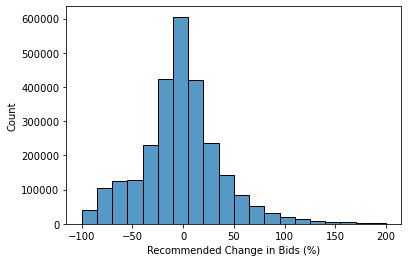

In [13]:
p = sns.histplot(data.loc[data["bid_dif_rel100"] < 200, "bid_dif_rel100"], bins = 20)
p.set_xlabel("Recommended Change in Bids (%)")
plt.show()

Next, we look at suggested changes in the bids by subgroup. Starting with subgroups by CTR. Here, CTR values are calculated for all the clusters used to identify $g$. CTR is then categorized into 4 bins by quartile. These quartiles roughly correspond to CTR < 0.034 (low), 0.034 < CTR < 0.081 (medium), 0.081 < CTR < 0.113 (high), and CTR > 0.113 (very high). 

If it seems strange that the suggested relative bid increase is higher for the "high" than the "very high" bin, remember that these are deviations from the existing bids. Apparently, the advertiser is already doing a good job bidding adequately on those very high CTR targets. 

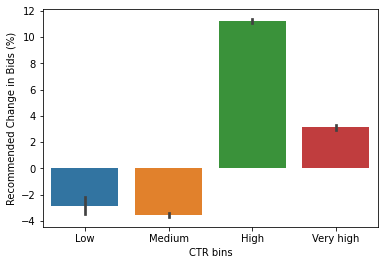

In [14]:
data[["imp_g", "clicks_g"]] = (data[["impressions", "clicks"]]
                            .groupby(data["id_g"])
                            .transform(np.sum)
                            )
data["ctr_g"] = 100 * data["clicks_g"] / data["imp_g"]
data["ctr_category"] = 1
data.loc[(data["ctr_g"] > data["ctr_g"].quantile(q=0.25)), "ctr_category"] = 2
data.loc[data["ctr_g"] > data["ctr_g"].quantile(q=0.5), "ctr_category"] = 3
data.loc[data["ctr_g"] > data["ctr_g"].quantile(q=0.75), "ctr_category"] = 4

p = sns.barplot(x="ctr_category", y="bid_dif_rel100", data=data)
p.set_xlabel("CTR bins")
p.set_ylabel("Recommended Change in Bids (%)")
p.set_xticklabels(["Low", "Medium", "High", "Very high"])
plt.show()

Looking at device type. Recommendation: bid more on tablet viewers, less on PC viewers. 

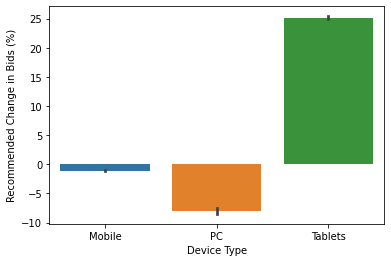

In [15]:
p = sns.barplot(x="device_type", y="bid_dif_rel100", data=data)
p.set_xlabel("Device Type")
p.set_ylabel("Recommended Change in Bids (%)")
plt.show()

Looking at retargeted vs. first time viewers. Recommendation: bid more on first time viewers. 

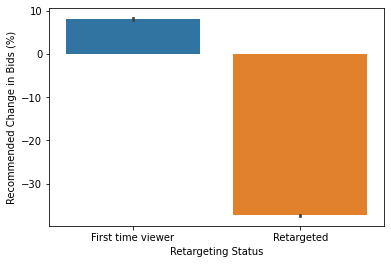

In [16]:
p = sns.barplot(x="RT", y="bid_dif_rel100", data=data)
p.set_xlabel("Retargeting Status")
p.set_ylabel("Recommended Change in Bids (%)")
p.set_xticklabels(["First time viewer", "Retargeted"])
plt.show()

Look at the hour of the day. Recommendation: bid less in the early morning (3:00-8:00) and more in 
the evening (18:00-24:00).

/tmp/ipykernel_6933/3305199684.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_xticklabels(['0', '0:00', '5:00', '10:00', '15:00', '20:00'])


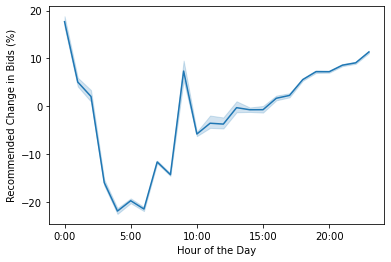

In [17]:
p = sns.lineplot(data = data, x="hour_user_tz", y="bid_dif_rel100")
p.set_xlabel("Hour of the Day")
p.set_ylabel("Recommended Change in Bids (%)")
p.set_xticklabels(['0', '0:00', '5:00', '10:00', '15:00', '20:00'])
plt.show()

Look at the day of the week. 

/tmp/ipykernel_6933/785006375.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  p.set_xticklabels(['bla', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])


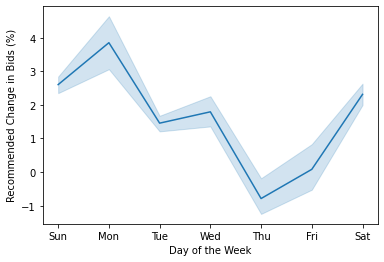

In [18]:
p = sns.lineplot(data = data, x="weekday_user_tz", y="bid_dif_rel100")
p.set_xlabel("Day of the Week")
p.set_ylabel("Recommended Change in Bids (%)")
p.set_xticklabels(['bla', 'Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
plt.show()